## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'all_data_types_results',
                   'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(
    ['expression', 'rppa', 'mirna', 'mut_sigs']
)]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(17184, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99588,0.935600,MAP3K1,expression,signal,42,train,0,gene
1,0.49030,0.067637,MAP3K1,expression,signal,42,test,0,gene
2,0.63147,0.178390,MAP3K1,expression,signal,42,cv,0,gene
3,0.93186,0.684940,MAP3K1,expression,signal,42,train,1,gene
4,0.65948,0.213840,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(8592, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.95992,0.68712,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.76966,0.17595,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.56200,0.11758,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,0.97666,0.83335,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.63793,0.12212,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(25776, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99588,0.935600,MAP3K1,expression,signal,42,train,0,gene,raw
1,0.49030,0.067637,MAP3K1,expression,signal,42,test,0,gene,raw
2,0.63147,0.178390,MAP3K1,expression,signal,42,cv,0,gene,raw
3,0.93186,0.684940,MAP3K1,expression,signal,42,train,1,gene,raw
4,0.65948,0.213840,MAP3K1,expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_results_df = au.compare_results(results_df[results_df.training_data == training_data],
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
# now filter out genes that don't have comparisons for all data types
data_type_counts = all_results_df.groupby('gene').count().training_data
valid_genes = data_type_counts[data_type_counts == len(results_df.training_data.unique())].index
all_results_df = all_results_df[
    all_results_df.gene.isin(valid_genes)
]

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data
15,BRAF,0.524171,3.080457e-18,2.895630e-16,True,mirna
15,BRAF,0.543944,2.558495e-17,2.404985e-15,True,me_450k
4,APC,0.546344,1.706323e-16,8.019717e-15,True,me_450k
91,TP53,0.325990,2.607498e-16,2.451048e-14,True,me_27k
15,BRAF,0.559362,3.554518e-16,3.341247e-14,True,expression
77,PTEN,0.515649,8.636554e-16,8.118361e-14,True,rppa
91,TP53,0.400176,1.920114e-15,9.024534e-14,True,expression
91,TP53,0.314781,2.090573e-15,9.825695e-14,True,rppa
4,APC,0.582791,5.835815e-15,1.828555e-13,True,expression
15,BRAF,0.470060,8.383395e-15,3.040884e-13,True,me_27k


expression: 43/94
me_27k: 35/94
me_450k: 35/94
mirna: 29/94
mut_sigs: 6/94
rppa: 32/94


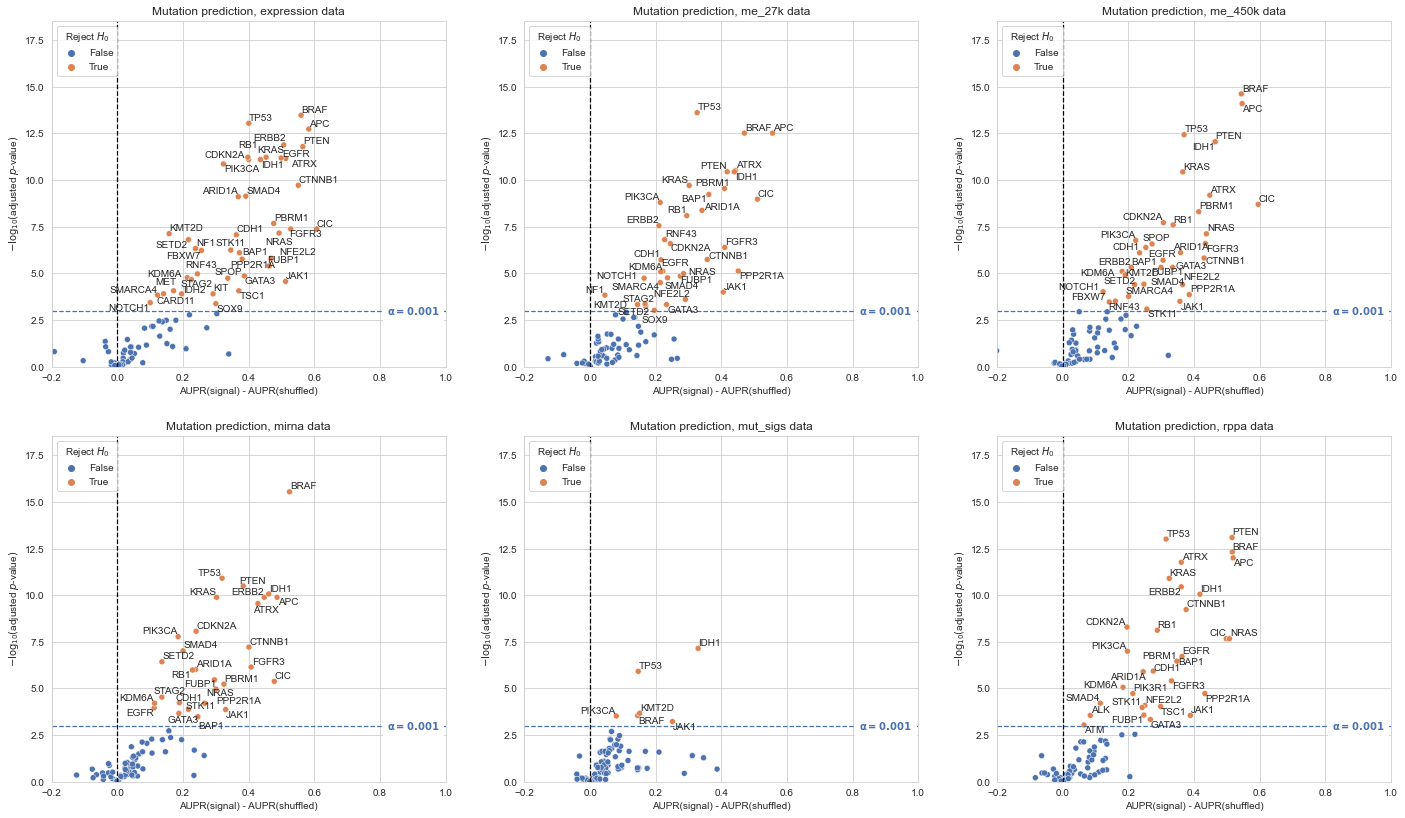

In [7]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (24, 14)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, training_data in enumerate(sorted(all_results_df.training_data.unique())):
    ax = axarr[ix // 3, ix % 3]
    data_results_df = all_results_df[all_results_df.training_data == training_data]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {} data'.format(training_data))

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(
        training_data,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0]
    ))

me_27k: 9/94
me_450k: 3/94
mirna: 10/94
mut_sigs: 35/94
rppa: 11/94


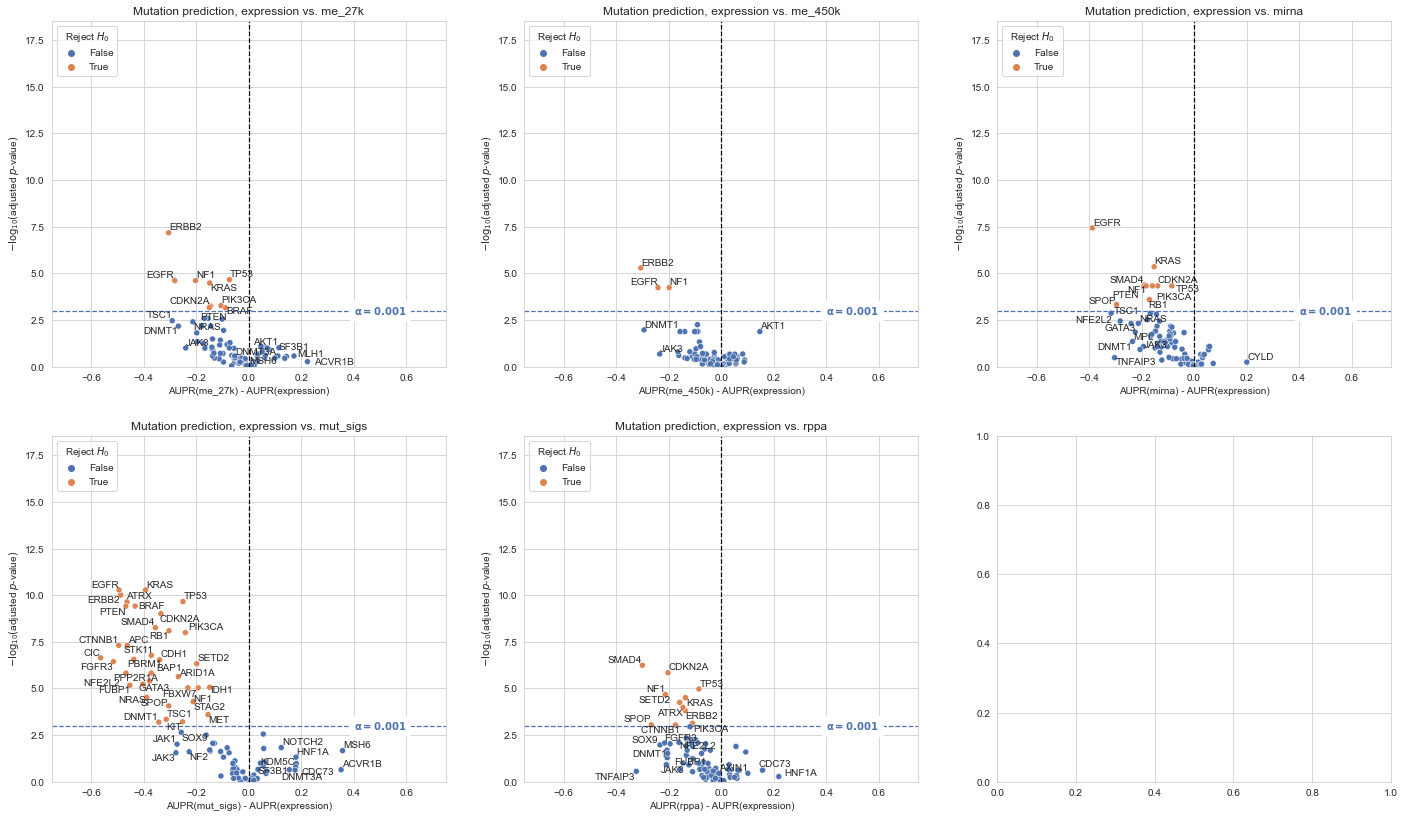

In [8]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if (point['y'] > -np.log10(0.001)) or (point['x'] > 0.1) or (abs(point['x']) > 0.2):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

sns.set({'figure.figsize': (24, 14)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.75, 0.75)
# TODO: maybe adjust these afterward?
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

data_types = sorted([dt for dt in all_results_df.training_data.unique() if dt != 'expression'])
exp_results_df = results_df[results_df.training_data == 'expression']

for ix, training_data in enumerate(data_types):
    ax = axarr[ix // 3, ix % 3]
    data_results_df = results_df[results_df.training_data == training_data]
    compare_results_df = au.compare_results(exp_results_df,
                                            pancancer_df=data_results_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
    compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
    sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)

    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.5, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR({}) - AUPR(expression)'.format(training_data))
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, expression vs. {}'.format(training_data))

    text_labels = label_points(compare_results_df['delta_mean'],
                               compare_results_df['nlog10_p'],
                               compare_results_df.gene,
                               ax)
    adjust_text(text_labels,
                ax=ax,
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(training_data,
                             np.count_nonzero(compare_results_df.reject_null),
                             compare_results_df.shape[0]))

(-0.2, 0.6568862500000001)

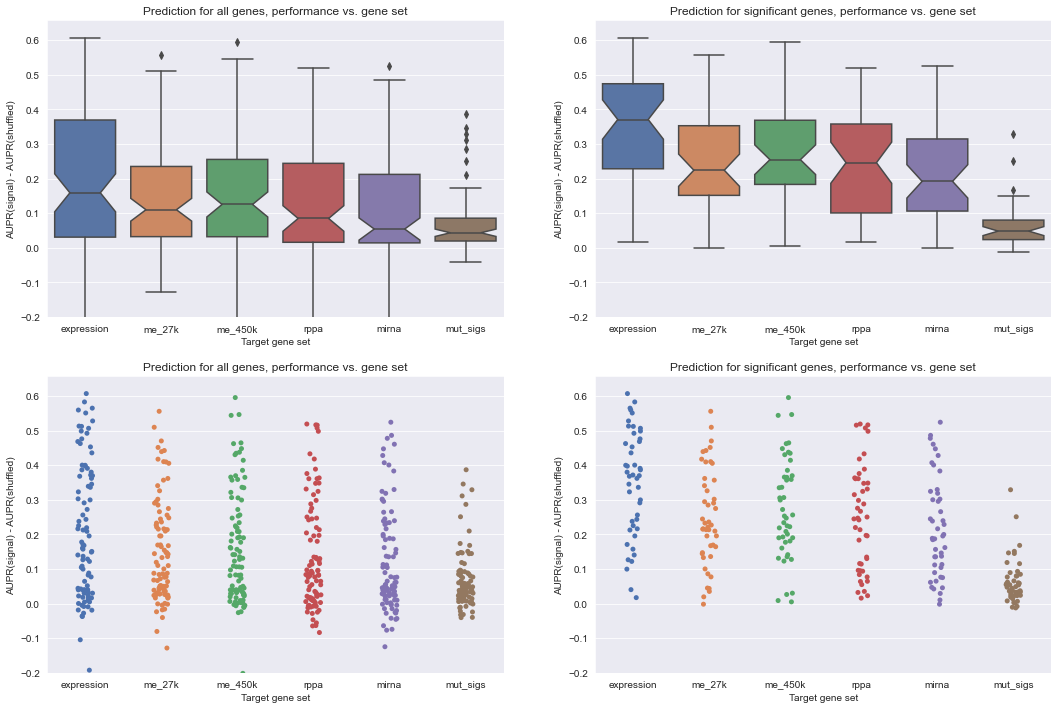

In [9]:
sns.set({'figure.figsize': (18, 12)})
fig, axarr = plt.subplots(2, 2)

data_order = ['expression', 'me_27k', 'me_450k', 'rppa', 'mirna', 'mut_sigs']

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=all_results_df, x='training_data', y='delta_mean',
            order=data_order, notch=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
sns.boxplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
            x='training_data', y='delta_mean', order=data_order, 
            notch=True, ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=all_results_df, x='training_data', y='delta_mean', dodge=True, 
              order=data_order, ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
              x='training_data', y='delta_mean', dodge=True, order=data_order, ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))